In [22]:
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [2]:
class VectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25, **kwargs):
        super().__init__(name="vector_quantizer", **kwargs)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.beta = beta

        w_init = tf.random_uniform_initializer()
        self.embeddings = tf.Variable(
            initial_value=w_init(
                shape=(self.embedding_dim, self.num_embeddings), dtype="float32"),
            trainable=True,
            name="embedding_vqvae")
        
    def call(self, x):
        # Calculate the input shape of the inputs and then flatten the inputs keeping 'embedding_dim' intact
        input_shape = tf.shape(x)
        flattened = tf.reshape(x, [-1, self.embedding_dim])
    
        # Quantization
        encoding_indices = self.get_code_indices(flattened)
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        quantized = tf.matmul(encodings, self.embeddings, transpose_b=True)
        quantized = tf.reshape(quantized, input_shape)

        # Calculate vector quantization loss and add that to the layers
        commitment_loss = self.beta * tf.reduce_mean(
            (tf.stop_gradient(quantized) - x) ** 2)
        
        codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)

        self.add_loss(commitment_loss + codebook_loss)

        quantized = x + tf.stop_gradient(quantized - x)
        return quantized

    def get_code_indices(self, flattened_inputs):
        similarity = tf.matmul(flattened_inputs, self.embeddings)
        distances = (
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(self.embeddings ** 2, axis=0)
            - (similarity * 2))
        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices

In [3]:
def get_decoder(latent_dim=16):
    decoder_inputs = layers.Input(shape=get_encoder().output.shape[1:])
    x = layers.Conv2DTranspose(
        64, 3, activation='relu', strides=2, padding='same')(decoder_inputs)
    x = layers.Conv2DTranspose(
        32, 3, activation='relu', strides=2, padding='same')(x)
    decoder_outputs = layers.Conv2DTranspose(
        1, 3, padding='same')(x)
    return tf.keras.Model(decoder_inputs, decoder_outputs, name="decoder")

In [14]:
class Encoder(tf.keras.Model):
    def __init__(self, latent_dim):
        super().__init__(name="encoder")
        self.conv1 = layers.Conv2D(
            32, 3, activation='relu', strides=2, padding='same')
        self.conv2 = layers.Conv2D(
            64, 3, activation='relu', strides=2, padding='same')
        self.conv3 = layers.Conv2D(
            latent_dim, 1, padding='same')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        return self.conv3(x)

class Decoder(tf.keras.Model):
    def __init__(self, latent_dim):
        super().__init__(name="decoder")
        self.conv1 = layers.Conv2DTranspose(
            64, 3, activation='relu', strides=2, padding='same')
        self.conv2 = layers.Conv2DTranspose(
            32, 3, activation='relu', strides=2, padding='same')
        self.conv3 = layers.Conv2DTranspose(
            latent_dim, 3, padding='same')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        return self.conv3(x)

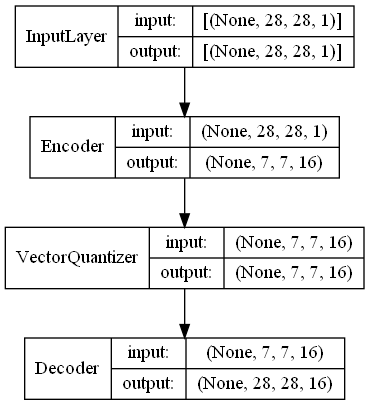

In [15]:
def get_vqvae(latent_dim=16, num_embeddings=64):
    vq_layer = VectorQuantizer(num_embeddings, latent_dim)
    encoder = Encoder(latent_dim)
    decoder = Decoder(latent_dim)
    inputs = layers.Input(shape=(28, 28, 1), name="input")
    encoder_outputs = encoder(inputs)
    quantized_latents = vq_layer(encoder_outputs)
    reconstructions = decoder(quantized_latents)
    return tf.keras.Model(inputs, reconstructions, name="vq_vae")

vqvae = get_vqvae()
tf.keras.utils.plot_model(
    vqvae, to_file="vqvae.png", show_shapes=True, rankdir='TB',
    show_layer_names=False)

In [16]:
class VQVAETrainer(tf.keras.models.Model):
    def __init__(self, train_variance, latent_dim=32, 
            num_embeddings=128, **kwargs):
        super(VQVAETrainer, self).__init__(**kwargs)
        self.train_variance = train_variance
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings
        self.vqvae = get_vqvae(self.latent_dim, self.num_embeddings)
        self.total_loss = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.vq_loss = tf.keras.metrics.Mean(name="vq_loss")

    @property
    def metrics(self):
        return [
            self.total_loss,
            self.reconstruction_loss,
            self.vq_loss]

    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Outputs from vq-vae
            reconstructions = self.vqvae(x)

            # Calculate the losses
            reconstruction_loss = (
                tf.reduce_mean((x - reconstructions) ** 2) / self.train_variance)
            total_loss = reconstruction_loss + sum(self.vqvae.losses)

        # Backprop
        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))

        # Loss tracking
        self.total_loss.update_state(total_loss)
        self.reconstruction_loss.update_state(reconstruction_loss)
        self.vq_loss.update_state(sum(self.vqvae.losses))

        # Log results
        return {
            "loss": self.total_loss.result(),
            "reconstruction_loss": self.reconstruction_loss.result(),
            "vqvae_loss": self.vq_loss.result()}

In [17]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_train_scaled = (x_train/255.0) - 0.5
x_test_scaled = (x_test/255.0) - 0.5

data_variance = np.var(x_train/255.0)
print("Data Variance:", data_variance)

Data Variance: 0.09493041879725218


In [18]:
vqvae_trainer = VQVAETrainer(data_variance, latent_dim=16, num_embeddings=128)
vqvae_trainer.compile(optimizer=tf.keras.optimizers.Adam())
history = vqvae_trainer.fit(x_train_scaled, epochs=5, batch_size=128)

Epoch 1/5
469/469 [==============================] - 4s 7ms/step - loss: 1.9203 - reconstruction_loss: 0.3675 - vqvae_loss: 1.2001
Epoch 2/5
469/469 [==============================] - 3s 7ms/step - loss: 1.6951 - reconstruction_loss: 0.1512 - vqvae_loss: 1.5357
Epoch 3/5
469/469 [==============================] - 3s 7ms/step - loss: 0.8060 - reconstruction_loss: 0.1186 - vqvae_loss: 0.6812
Epoch 4/5
469/469 [==============================] - 4s 8ms/step - loss: 0.5386 - reconstruction_loss: 0.1000 - vqvae_loss: 0.4348
Epoch 5/5
469/469 [==============================] - 3s 7ms/step - loss: 0.4374 - reconstruction_loss: 0.0883 - vqvae_loss: 0.3468


In [19]:
trained_vqvae_model = vqvae_trainer.vqvae
idx = np.random.choice(len(x_test_scaled), 10)
test_images = x_test_scaled[idx]
reconstructions_test = trained_vqvae_model.predict(test_images)

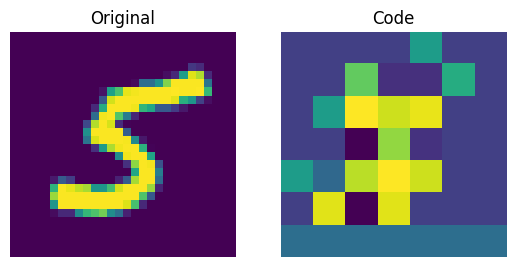

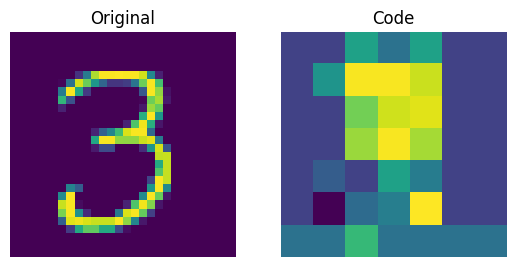

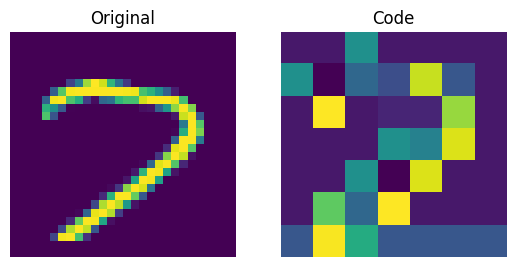

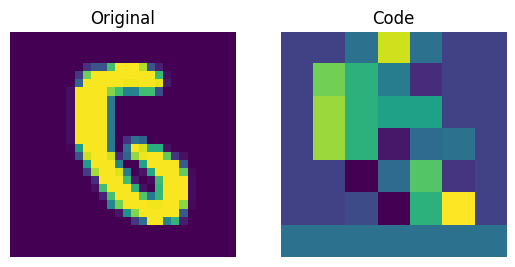

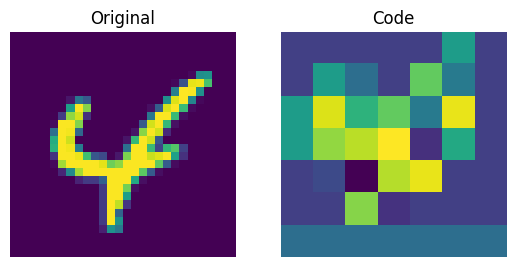

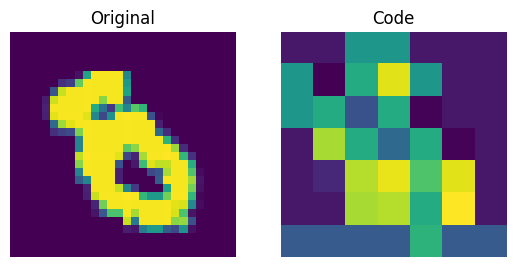

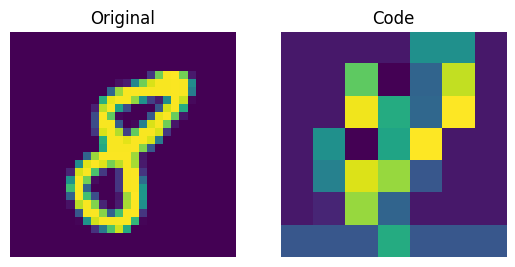

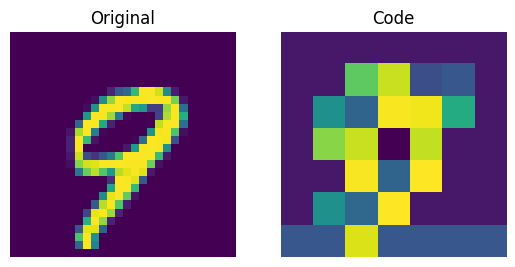

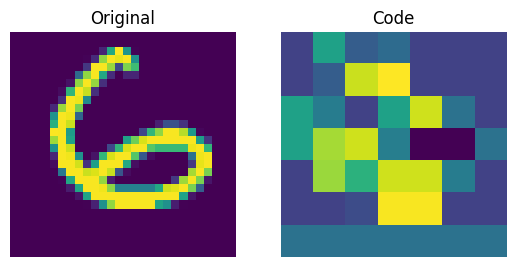

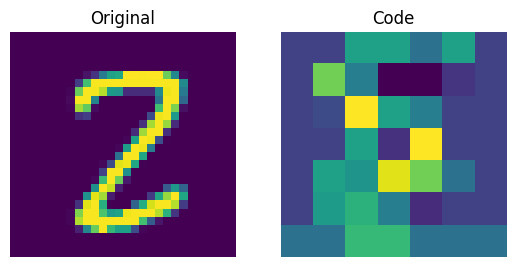

In [23]:
encoder = vqvae_trainer.vqvae.get_layer("encoder")
quantizer = vqvae_trainer.vqvae.get_layer("vector_quantizer")

encoded_outputs = encoder.predict(test_images)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)
codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])

for i in range(len(test_images)):
    plt.subplot(1, 2, 1)
    plt.imshow(test_images[i].squeeze() + 0.5)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(codebook_indices[i])
    plt.title("Code")
    plt.axis("off")
    plt.show()